In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import pandas as pd
import glob
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats

import sys; sys.path.insert(1, '/home/alessandro/thesis_material')
import os

import geometry as gm
#import conversion as cnv
#from func_statistics import compute_pdf_nbin, slopes_r_p, slope_time, slope_maps
#from coare_functions import *

import meteo
import metpy.calc as mpcalc
from metpy.units import units
import lcl


import cartopy.crs as ccrs
crs = ccrs.PlateCarree()
#from plotmap import plot_background

from plotdistr import * #fb_distribution_npoint, perc_distribution, scatterplot_fit, hist2d, perc_distribution_pvalue
from pdist_fb_distrib_save_fast import *

import warnings; warnings.filterwarnings("ignore")

In [2]:
# find data
path = '/saturn/simu_Caribbean/coupled_2km/output/'
files_ls = ['QCLOUD', 'U', 'V', 'W', 'OLR', 'PH', 'PHB', 'QVAPOR', 'PB', 'P', 'T']
files_ls = [name + '.nc' for name in files_ls]
wrf_files = [path+name for name in files_ls]
#fname_list = sorted(glob.glob(wrf_files + '*'))

In [4]:
# import sea_mask
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/sea_mask_EU_new.npy'):
    sea_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/sea_mask_EU_new.npy')
    
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_noWarmPatch_noWest.npy'):
    sea_mask_modified = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_noWarmPatch_noWest.npy')


SAVE QVAPOR

In [6]:
#### list of dates for slicing 
dates_start =  ['2020-02-01T01:30:00.000000000', '2020-02-09T01:30:00.000000000',\
                '2020-02-17T01:30:00.000000000', '2020-02-26T01:30:00.000000000']

dates_end = ['2020-02-08T22:30:00.000000000','2020-02-16T22:30:00.000000000',\
             '2020-02-25T22:30:00.000000000', '2020-02-29T22:30:00.000000000']

In [28]:
# load data
QVAPOR = xr.open_dataset(wrf_files[files_ls.index('QVAPOR.nc')])
QVAPOR = QVAPOR['QVAPOR'].sel(time_counter=slice(dates_start[3], dates_end[3]))
QVAPOR = QVAPOR.where(sea_mask, drop=False)


In [6]:
# # select data oversea
# # QVAPOR_day = QVAPOR.groupby('time_counter.day').mean()
# QVAPOR_day = QVAPOR_day.where(sea_mask, drop=False)

GEOPOTENTIAL AND PRESSURE

In [7]:
pres_base = xr.open_dataset(wrf_files[files_ls.index('PB.nc')])
pres_base = pres_base['PB']

pres = xr.open_dataset(wrf_files[files_ls.index('P.nc')])
pres = pres['P'].sel(time_counter=slice(dates_start[0], dates_end[-1]))

pres = (pres+pres_base)/100.                # hectoPascals
pres = pres.where(sea_mask_modified, drop=False)
pres_sfc = pres[:,0,:,:]

del pres_base, pres

In [8]:
pres_sfc.shape

(232, 546, 573)

OPENING HOURLY DATASETS

In [9]:
wrf_hourly = path + 'Caraibes_WRF_3h_surf.nc'
ds_hourly = xr.open_dataset(wrf_hourly)
ds_hourly = ds_hourly.sel(time_counter=slice(dates_start[0], dates_end[-1]))


In [11]:
# daily varaibles
# select sst, q2, U, PBLH

T2 = ds_hourly['T2']    
T2 = T2.where(sea_mask_modified, drop=False).values; 


sst = ds_hourly['SST']
sst = sst.where(sea_mask_modified, drop=False).values; 

q2 = ds_hourly['Q2']
q2 = q2.where(sea_mask_modified, drop=False).values;   


In [12]:
#### MAKE SURFACE DATA 3HOURLY AS WELL
#### 
T2_3hr = T2[::3,:,:]
sst_3hr = sst[::3,:,:]
q2_3hr = q2[::3,:,:]

In [ ]:
#   CHECKING THE RH DISTRIBUTIONS, INSTEAD OF ABSOLUTE MOISTURE MAGNITUDES

In [30]:
# retrieve potential temperature
pot_temp = xr.open_dataset(wrf_files[files_ls.index('T.nc')])
pot_temp = pot_temp['T']
pot_temp = pot_temp.sel(time_counter=slice(dates_start[3], dates_end[3]))

# full pot_temp field
# = T+T0 , T0 = 300
pot_temp = pot_temp + 300

In [31]:
# compute actual temperature
# I DID NOT APPLY DAILY MEAN TO PRES!
temperature = pot_temp * ( pres / 1000. )**0.286
temperature = temperature.where(sea_mask, drop=False)
del pot_temp

In [20]:
# compute relative humidity
# RESULT IN %
rh2 = meteo.rhcalc(T2_3hr-273.15, pres_sfc.values, q2_3hr)

In [21]:
rh2 = xr.DataArray(rh2, dims=['time_counter', 'lat', 'lon'],\
                   name='rh2_3h', \
                  coords={'time_counter':ds_hourly.time_counter[::3]}); 

rh2.attrs['long_name'] = '3h relative humidity at 2m'
rh2.attrs['units'] = '%'

In [22]:
RH = xr.open_dataset('/venus/tesi_ale/data_EU/RH/daily/FEB/RH.nc')
RH['rh2_3h'] = rh2

RH.to_netcdf('/venus/tesi_ale/data_EU/RH/daily/FEB/RH_new.nc')

In [17]:
num_days = int(rh2.shape[0]/8)
rh2_day = np.empty((num_days, *rh2.shape[1:]))

for i in range(num_days):
    rh2_day[i] = np.nanmean( rh2[ i*8:(i+1)*8 ,:,:] , axis=0)

In [18]:
my_save_data('/venus/tesi_ale/data_EU/RH/daily/FEB/rh2_day.npy', [rh2_day])

In [20]:
# compute anomalies
s = 100
drh2_day = np.zeros_like(rh2_day)

for t in range(0,rh2_day.shape[0]):
    if t % 10 == 0:
        print(t)
    rh_ave = gm.nan_gaussian_filter(rh2_day[t],s)                             
    drh2_day[t] = rh2_day[t] - rh_ave
    

0
10
20


In [21]:
my_save_data('/venus/tesi_ale/data_EU/RH/daily/FEB/drh2_day.npy', [drh2_day])

In [4]:
rh_fst = np.load('/venus/tesi_ale/data_EU/RH/daily/FEB/rh_fst.npy')
rh_snd = np.load('/venus/tesi_ale/data_EU/RH/daily/FEB/rh_snd.npy')
rh_trd = np.load('/venus/tesi_ale/data_EU/RH/daily/FEB/rh_trd.npy')
rh_lst = np.load('/venus/tesi_ale/data_EU/RH/daily/FEB/rh_lst.npy')

In [5]:
rh_day = np.concatenate([rh_fst,rh_snd,rh_trd,rh_lst], axis=0)

In [8]:
del rh_fst, rh_snd, rh_trd, rh_lst

In [6]:
num_days = int(rh_day.shape[0]/8)
daily_mean_rh = np.empty((num_days, *rh_day.shape[1:]))

for i in range(num_days):
    daily_mean_rh[i] = np.nanmean( rh_day[ i*8:(i+1)*8 ,:,:,:] , axis=0)

In [9]:
my_save_data('/venus/tesi_ale/data_EU/RH/daily/FEB/rh_day.npy', [daily_mean_rh])

In [12]:
# compute anomalies
s = 100
drh_day = np.zeros_like(daily_mean_rh)

for t in range(0,daily_mean_rh.shape[0]):
    if t % 10 == 0:
        print(t)

    for h in range(0,daily_mean_rh.shape[1]):
        rh_ave = gm.nan_gaussian_filter(daily_mean_rh[t,h],s)                             
        drh_day[t,h] = daily_mean_rh[t,h] - rh_ave
    

0
10
20


In [14]:
my_save_data('/venus/tesi_ale/data_EU/RH/daily/FEB/drh_day.npy', [drh_day])

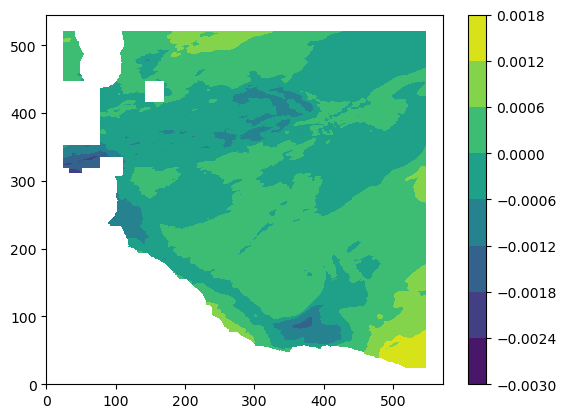

In [7]:
plt.contourf(dqsat2m_day[10,:,:])
plt.colorbar()

In [ ]:
###########  QSAT2M

In [39]:
##### calculate here qsat
qsat_2m = mpcalc.saturation_mixing_ratio(pres_sfc.values*units.hPa,\
                                         T2_3hr*units.kelvin).to('kg/kg')

qsat_2m = qsat_2m.magnitude

In [40]:
qsat_2m = qsat_2m/(1+qsat_2m)

In [44]:
np.nanmax(1000*qsat2m_day)

22.443577647209167

In [43]:
num_days = int(qsat_2m.shape[0]/8)
qsat2m_day = np.empty((num_days, *qsat_2m.shape[1:]))

for i in range(num_days):
    qsat2m_day[i] = np.nanmean( qsat_2m[ i*8:(i+1)*8 ,:,:] , axis=0)

In [45]:
my_save_data('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/qsat_2m_day.npy', [1000*qsat2m_day])

file already exists - DELETING IT and creating it anew


In [ ]:
####### QSAT SST

In [23]:
##### calculate here qsat
qsat_sst = mpcalc.saturation_mixing_ratio(pres_sfc.values*units.hPa,\
                                          sst_3hr*units.kelvin).to('kg/kg')

qsat_sst = qsat_sst.magnitude

qsat_sst = 1000*qsat_sst/(1+qsat_sst)

In [37]:
np.nanmax(dqsat2m_day)

1.1616674890287726

In [25]:
num_days = int(qsat_sst.shape[0]/8)
qsatsst_day = np.empty((num_days, *qsat_sst.shape[1:]))

for i in range(num_days):
    qsatsst_day[i] = np.nanmean( qsat_sst[ i*8:(i+1)*8 ,:,:] , axis=0)

In [27]:
my_save_data('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/qsat_sst_day.npy', [qsatsst_day])

file already exists - DELETING IT and creating it anew


In [4]:
qsat2m_day = np.load('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/qsat_2m_day.npy')

In [35]:
# compute anomalies
s = 100
dqsat2m_day = np.zeros_like(qsat2m_day)
dqsat_sst_day = np.zeros_like(qsatsst_day)

for t in range(0,qsat2m_day.shape[0]):
    if t % 10 == 0:
        print(t)
    qs2_ave = gm.nan_gaussian_filter(qsat2m_day[t],s)                             
    dqsat2m_day[t] = qsat2m_day[t] - qs2_ave
    
    qs_ave = gm.nan_gaussian_filter(qsatsst_day[t],s)                             
    dqsat_sst_day[t] = qsatsst_day[t] - qs_ave
    

0
10
20


In [38]:
my_save_data('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/dqsat_2m_day.npy', [dqsat2m_day])
my_save_data('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/dqsat_sst_day.npy', [dqsat_sst_day])

file already exists - DELETING IT and creating it anew
file already exists - DELETING IT and creating it anew


In [ ]:
##### QSAT 3D

In [32]:
##### calculate here qsat
qsat_lst = mpcalc.saturation_mixing_ratio(pres.values*units.hPa,\
                                         temperature.values*units.kelvin).to('kg/kg')

qsat_lst = qsat_lst.magnitude
qsat_lst = qsat_lst/(1+qsat_lst)

In [33]:
num_days = int(qsat_lst.shape[0]/8)
qsat_day_lst = np.empty((num_days, *qsat_lst.shape[1:]))

for i in range(num_days):
    qsat_day_lst[i] = np.nanmean( qsat_lst[ i*8:(i+1)*8 ,:,:] , axis=0)

In [34]:
my_save_data('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/qsat_day_lst.npy', [qsat_day_lst*1000])


file already exists - DELETING IT and creating it anew


In [36]:
qsat_day_fst = np.load('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/qsat_day_fst.npy')
qsat_day_snd = np.load('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/qsat_day_snd.npy')
qsat_day_trd = np.load('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/qsat_day_trd.npy')
qsat_day_lst = np.load('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/qsat_day_lst.npy')

In [37]:
qsat_day = np.concatenate([qsat_day_fst,qsat_day_snd,qsat_day_trd,qsat_day_lst], axis=0)

In [38]:
my_save_data('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/qsat_day.npy', [qsat_day])


file already exists - DELETING IT and creating it anew


In [39]:
# compute anomalies
s = 100
dqsat_day = np.zeros_like(qsat_day)

for t in range(0,qsat_day.shape[0]):
    if t % 10 == 0:
        print(t)

    for h in range(0,qsat_day.shape[1]):
        qsat_ave = gm.nan_gaussian_filter(qsat_day[t,h],s)                             
        dqsat_day[t,h] = qsat_day[t,h] - qsat_ave

0
10
20


In [40]:
my_save_data('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/dqsat_day.npy', [dqsat_day])


file already exists - DELETING IT and creating it anew


In [12]:
drh_day[:,0,220,330]

array([-1.42108547e-14, -4.97379915e-14, -1.42108547e-14, -2.84217094e-14,
       -5.68434189e-14, -3.55271368e-14,  0.00000000e+00, -5.68434189e-14,
       -2.84217094e-14, -4.26325641e-14, -9.23705556e-14, -4.97379915e-14,
       -2.84217094e-14, -7.10542736e-15, -7.10542736e-14, -2.84217094e-14,
       -4.26325641e-14, -4.26325641e-14,  0.00000000e+00, -2.84217094e-14,
       -2.84217094e-14, -2.13162821e-14, -7.10542736e-15, -2.84217094e-14,
       -2.84217094e-14, -4.26325641e-14, -4.26325641e-14, -9.23705556e-14,
       -5.68434189e-14])

In [9]:
rh2_day = np.load('/venus/tesi_ale/data_EU/RH/daily/FEB/rh2_day.npy')

In [11]:
my_save_data('/venus/tesi_ale/data_EU/RH/daily/FEB/drh2_day.npy', [drh2_day])

In [7]:
## load dRH
drh_day = np.load('/venus/tesi_ale/data_EU/RH/daily/FEB/drh_day.npy')

In [23]:
# correlation quantities

L = 30
nskip = int(L/2)
nt = int(1)

# from top pbl upwards
Ltop = 150
nskiptop = int(Ltop/2)
nttop = int(1)

# ref mean
popmean = 0.

In [24]:
# COMPUTE PERCENTILE DISTRIBUTIONS
perc_step = 5
nbins = int(100/perc_step) # Number of bins.
popmean = 0.

pdist_dsst, pdist_drh, pstd_drh, pstderr_drh, pnpoints_drh, ppvalue_drh_sub = \
dist_3d_subsample(dsst_day, drh_day, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='perc')

0
10
20
30


In [25]:
## load RH
my_save_data('/venus/tesi_ale/data_EU/RH/daily/FEB/pdistrs_dSST_dRH_day_feb.npy', [pdist_dsst, pdist_drh, pstd_drh, pstderr_drh, pnpoints_drh, ppvalue_drh_sub])

In [23]:
## load PBLH distributions
with open('/venus/tesi_ale/data_EU/PBLH/daily/FEB/pdistrs_PBLH_dSST_day_feb.npy', 'rb') as f:
    pdist_dsst = np.load(f)
    pdist_PBLH_dsst = np.load(f)

In [26]:
# compute distributions for PBLH_pres
# otherwise cannot be put in the plots
'''pdist_dsst, pdist_PBLHpr_dsst, pstd_PBLHpr, pstderr_PBLHpr, ppoints_PBLHpr, pvalue_PBLHpr_perc = \
distrib_2d(dsst_day, PBLH_pres, perc_step, nbins, popmean, perc_fixbin='perc')

dist_dsst, dist_PBLHpr_dsst, std_PBLHpr, stderr_PBLHpr, points_PBLHpr, pvalue_PBLHpr_fb = \
distrib_2d(dsst_day, PBLH_pres, perc_step, nbins, popmean, perc_fixbin='fb')'''

# distribution_control_fb, distribution_fb, std_err_distribution_fb, number_of_points_fb, p_value

/venus/tesi_ale/img_EU/RH/daily/FEB/pdist_dsst_drh_lowtropo_hatch.png


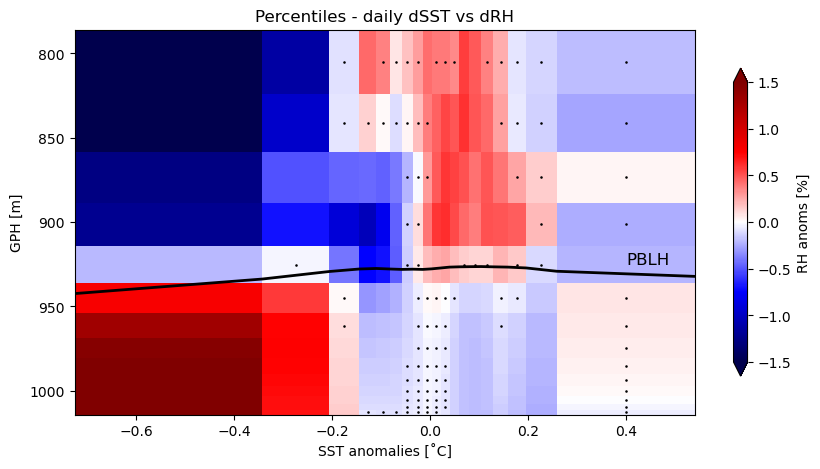

In [48]:
p_level_plot = int(15)

perc = True
title = 'Percentiles' if perc else 'Fixed bins'
x = pdist_dsst if perc else dist_dsst
var = pdist_drh if perc else dist_drh
minval = -1.5 ; maxval = -minval
#levs = np.arange(minval, maxval+0.1, 0.1)


fig, ax1 = plt.subplots(figsize=(10, 5))  
ax1.invert_yaxis()
p1 = ax1.pcolormesh(x, mean_vert_pres[0:p_level_plot], var[0:p_level_plot],\
                  vmin=minval, vmax=maxval, cmap='seismic')  #
# p1 = ax1.contourf(x, mean_vert_pres[0:p_level_plot], var[0:p_level_plot], \
#                   levels=levs, cmap='seismic')  #vmin=minval, vmax=maxval,
ax1.set_xlabel('SST anomalies [˚C]'); ax1.set_ylabel('GPH [m]')
plt.title(f'{title} - daily dSST vs dRH')
cbar = plt.colorbar(p1,ax=ax1, location='right', shrink=0.8, extend='both')  
cbar.set_label('RH anoms [%]')

var_pbl = pdist_PBLH_dsst if perc else dist_PBLHpr_dsst
ax1.plot(x, var_pbl, '-k', linewidth=2)
ax1.text(0.4, 925, 'PBLH', fontsize=12, color='k')



# DEF punti significativi (pvalue < 0.05)
pval = ppvalue_drh_sub[0:p_level_plot] if perc else pvalue_drh_sub[0:p_level_plot]
GPbin = mean_vert_pres[1:p_level_plot] - np.diff(mean_vert_pres[0:p_level_plot])*0.5
signif_Lcorr_H = np.zeros((len(mean_vert_pres[0:p_level_plot])-1,len(x)-1))
dsstbin = np.zeros((len(mean_vert_pres[0:p_level_plot])-1,len(x)-1))
for h in range(0,len(mean_vert_pres[0:p_level_plot])-1):
    cond1 = pval[h,:-1] > 0.05
    cond2 = np.abs(var[h,:-1]) < 0.1*np.nanmean(np.abs(var))
    cond = (cond1) | (cond2)
#     cond = cond1
    signif_Lcorr_H[h,:] = np.zeros(len(x)-1) + np.nan
    signif_Lcorr_H[h, cond] = GPbin[h]
    dsstbin[h,:] = x[1:] - np.diff(x)*0.5
    
plt.scatter(dsstbin,signif_Lcorr_H,  s=0.7, color='k')



# savefig
path_img = '/venus/tesi_ale/img_EU/RH/daily/FEB/' #if perc else '/venus/tesi_ale/img_EU/RH/daily/bins/FEB/'
filename = path_img + 'pdist_dsst_drh_lowtropo_hatch.png' #if perc else path_img + 'bins_dsst_drh_lowtropo_hatch.png'
#plt.savefig(filename)
print(filename)
del filename


In [52]:
mean_vert_pres[8]

954.05237

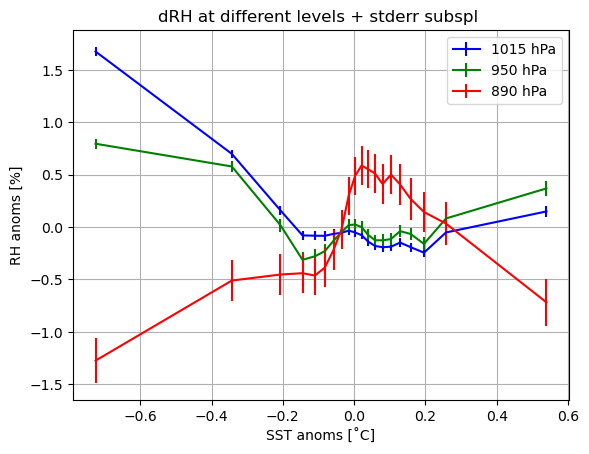

In [54]:
plt.errorbar(pdist_dsst, pdist_drh[0,:], yerr=pstderr_drh[0,:], xerr=None,\
             label='1015 hPa', ecolor='b', linestyle='-', color='b')

plt.errorbar(pdist_dsst, pdist_drh[8,:], yerr=pstderr_drh[8,:], xerr=None,\
             label='950 hPa', ecolor='g', linestyle='-', color='g')

plt.errorbar(pdist_dsst, pdist_drh[11,:], yerr=pstderr_drh[11,:], xerr=None,\
             label='890 hPa', ecolor='r', linestyle='-', color='r')


plt.grid()
plt.legend()

plt.ylabel('RH anoms [%]')
plt.xlabel('SST anoms [˚C]')
plt.title('dRH at different levels + stderr subspl ')

# plt.savefig('/venus/tesi_ale/img_EU/RH/daily/FEB/dRH_levels.png')

In [ ]:
# study distributions of saturation mixing ratio

In [16]:
'''temperature = temperature.where(sea_mask, drop=False)'''

In [ ]:
'''qsat_full_fields = mpcalc.saturation_mixing_ratio(pres*units.hPa,temperature*units.K).to('g/kg')'''

In [18]:
#####  NOW APPLY DAILY MEAN TO PRES
pres_day = pres.groupby('time_counter.day').mean()
# T_day = temperature.groupby('time_counter.day').mean()

In [23]:
qsat_avg_fields = mpcalc.saturation_mixing_ratio(pres_day.values*units.hPa,temperature.values*units.kelvin).to('g/kg')

In [25]:
s = 100

dqsat_avg = np.zeros(qsat_avg_fields.shape)

for t in range(0,sst_day.shape[0]):
    if t % 10 == 0:
        print(t)
    # upscale using gaussian filter
    for h in range(0,qsat_avg_fields.shape[1]):
        q_ave = gm.nan_gaussian_filter(qsat_avg_fields[t,h].magnitude,s)                            
        dqsat_avg[t,h] = qsat_avg_fields[t,h].magnitude - q_ave

0
10
20


In [27]:
my_save_data('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/dQSAT_avgfields_day_feb.npy', [dqsat_avg])

In [28]:
with open('/venus/tesi_ale/data_EU/SST/daily/FEB/dSST_day_feb.npy', 'rb') as f:
    dsst_day = np.load(f)

In [35]:
with open('/venus/tesi_ale/data_EU/PBLH/daily/FEB/pdistrs_PBLH_dSST_day_feb.npy', 'rb') as f:
    miao = np.load(f)
    pdist_PBLH_dsst = np.load(f)
    del miao 
    f.close()

In [30]:
# PERC DISTRIBUTION dQVAPOR vs dSST - DAILY + PVALUE SUBSAMPLED height dependent
perc_step = 5
nbins = int(100/perc_step) # Number of bins.

# percentiles
# x,y,perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top, perc_fixbin
# dist_x, dist_y, std_y, stderr_y, npoints_y, pvalue_y, pvalue_y_sub

pdist_dsst, pdist_qsat, pstd_qsat, pstderr_qsat, pnpoints_qsat, ppvalue_qsat_sub = \
dist_3d_subsample(dsst_day, dqsat_avg, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='perc')


my_save_data('/venus/tesi_ale/data_EU/QVAPOR/daily/FEB/pdistrs_dsst_dQSAT_avgfields_day_feb.npy', [pdist_dsst, pdist_qsat, pstd_qsat, pstderr_qsat, pnpoints_qsat, ppvalue_qsat_sub])

0
10
20
30


In [31]:
### LOAD PRESSURE COLUMN
mean_vert_pres = np.load('/venus/tesi_ale/data_EU/PRES/daily/FEB/mean_vert_pres.npy')

/venus/tesi_ale/img_EU/QVAPOR/daily/FEB/pdist_dsst_dQSAT_avgfields_lowtropo_hatch.png


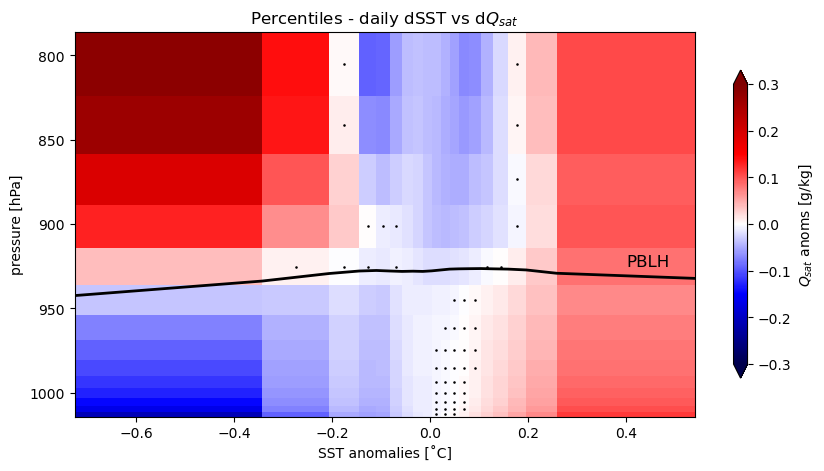

In [38]:
p_level_plot = int(15)

perc = True
title = 'Percentiles' #if perc else 'Fixed bins'
x = pdist_dsst #if perc else dist_dsst
var = pdist_qsat #if perc else dist_drh
minval = -.3 ; maxval = -minval
#levs = np.arange(minval, maxval+0.1, 0.1)


fig, ax1 = plt.subplots(figsize=(10, 5))  
ax1.invert_yaxis()
p1 = ax1.pcolormesh(x, mean_vert_pres[0:p_level_plot], var[0:p_level_plot],\
                  vmin=minval, vmax=maxval, cmap='seismic')  #
ax1.set_xlabel('SST anomalies [˚C]'); ax1.set_ylabel('pressure [hPa]')
plt.title(str(title)+' - daily dSST vs d$Q_{sat}$')
cbar = plt.colorbar(p1,ax=ax1, location='right', shrink=0.8, extend='both')  
cbar.set_label('$Q_{sat}$ anoms [g/kg]')

var_pbl = pdist_PBLH_dsst if perc else dist_PBLHpr_dsst
ax1.plot(x, var_pbl, '-k', linewidth=2)
ax1.text(0.4, 925, 'PBLH', fontsize=12, color='k')



# DEF punti significativi (pvalue < 0.05)
pval = ppvalue_qsat_sub[0:p_level_plot] #if perc else pvalue_drh_sub[0:p_level_plot]
GPbin = mean_vert_pres[1:p_level_plot] - np.diff(mean_vert_pres[0:p_level_plot])*0.5
signif_Lcorr_H = np.zeros((len(mean_vert_pres[0:p_level_plot])-1,len(x)-1))
dsstbin = np.zeros((len(mean_vert_pres[0:p_level_plot])-1,len(x)-1))
for h in range(0,len(mean_vert_pres[0:p_level_plot])-1):
    cond1 = pval[h,:-1] > 0.05
    cond2 = np.abs(var[h,:-1]) < 0.1*np.nanmean(np.abs(var))
    cond = (cond1) | (cond2)
#     cond = cond1
    signif_Lcorr_H[h,:] = np.zeros(len(x)-1) + np.nan
    signif_Lcorr_H[h, cond] = GPbin[h]
    dsstbin[h,:] = x[1:] - np.diff(x)*0.5
    
plt.scatter(dsstbin,signif_Lcorr_H,  s=0.7, color='k')



# savefig
path_img = '/venus/tesi_ale/img_EU/QVAPOR/daily/FEB/' #if perc else '/venus/tesi_ale/img_EU/RH/daily/bins/FEB/'
filename = path_img + 'pdist_dsst_dQSAT_avgfields_lowtropo_hatch.png' #if perc else path_img + 'bins_dsst_drh_lowtropo_hatch.png'
# plt.savefig(filename)
print(filename)
del filename